In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import GPyOpt
import gpflow
import tensorflow as tf

import scipy as sp
from scipy.optimize import basinhopping
from numba import jit

import matplotlib.pyplot as plt

## def objective

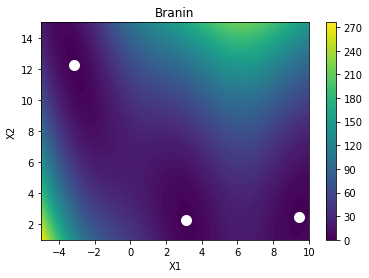

In [2]:
objective_true  = GPyOpt.objective_examples.experiments2d.branin()                 # true function
objective_noisy = GPyOpt.objective_examples.experiments2d.branin(sd = 0.1)         # noisy version
bounds = objective_noisy.bounds     
objective_true.plot()

In [3]:
objective_true

In [4]:
bounds

[(-5, 10), (1, 15)]

In [5]:
def generate_init(bounds, initial_n):
    dim = len(bounds)
    init_x = np.random.rand(initial_n, dim)
    for i in range(dim):
        init_x[:,i]=init_x[:,i]*(bounds[i][1]-bounds[i][0])+bounds[i][0]
    return init_x

In [6]:
h=2
N = 12

In [7]:
def bayesianOptimization(func_objective,
                         func_acq,
                         bounds,
                         kernel,
                         depth_h,
                         N,
                         initial_n=1,
                         N_q=3):
    """
    depth_h: num of nest
    N: num of iter
    """
    if depth_h > N:
        print("depth_h > N")
        return 0
    elif initial_n > N:
        print("initial_n > N")
        return 0
    
    _N = N - initial_n
    queries = generate_init(bounds, initial_n)
    values = func_objective(queries)
    for i in range(_N):
        print(i)
        #kernel = gpflow.kernels.RBF(len(bounds), ARD=True)
        #gp_model = fit(queries, values)
        _h = min({depth_h,_N-i})
        _count_depth = 0
        _gp_list = {}
        _queries_list = {}
        _values_list = {}
        _trajectory = []
        #_idlist = []
        if func_acq == ei:
            GP_model = fit(queries, values, kernel)
            facq = lambda x : -1*ei(x,bounds,GP_model)
        else:
            facq = lambda x : -1*func_acq(x, 
                                      bounds = bounds,
                                      func_policy=policy, 
                                      depth_h = _h, 
                                      _queries = queries,
                                      _values = values,
                                      kernel = kernel,
                                      N_q = N_q)
        X = minimize(facq, bounds)
        Y = func_objective(X)
        queries = np.concatenate([queries,X])
        values = np.concatenate([values,Y])
    return queries, values

In [8]:
#@jit
def policy(GP_model, depth_h,bounds):
    # caluc policy function
    if depth_h > 0:
        func2minimize = lambda x : -1*ei(x,bounds,GP_model)
    else:
        func2minimize = lambda x : mu(x,bounds,GP_model)
    query = minimize(func2minimize, bounds)
    return query

In [9]:
#Done: 獲得価値観数EI
@jit
def ei(x,bounds,GP_model,jitter=0.):
    if len(x.shape) == 1:
        x = np.array([x])
    mu, sig = GP_model.predict_f(x)
    fmin = GP_model.predict_f(GP_model.X.value)[0].min()
    if isinstance(sig, np.ndarray):
        sig[sig<1e-10] = 1e-10
    elif sig< 1e-10:
        sig = 1e-10
    u = (fmin - mu - jitter)/sig
    phi = np.exp(-0.5 * u**2) / np.sqrt(2*np.pi)
    Phi = 0.5 * sp.special.erfc(-u / np.sqrt(2))
    next_x = sig * (u * Phi + phi)
    return next_x

In [10]:
#Done: 獲得価値観数 mean
@jit
def mu(x, bounds, GP_model):
    if len(x.shape) == 1:
        x = np.array([x])
    mu = GP_model.predict_f(x)[0]
    return mu

In [11]:
#@jit
def rollout_utility(x,
                    bounds,
                    func_policy, 
                    depth_h, 
                    _queries, 
                    _values, 
                    kernel,
                    N_q,
                    decay_rate=0.9):
    global _h
    global _gp_list
    global _queries_list
    global _values_list
    global _trajectory
    if len(x.shape) == 1:
        x = np.array([x])
    if depth_h == 0:
        gp_model = fit(_queries, _values, kernel)
        U = ei(x,bounds ,gp_model)
    else:    
        curr_depth = _h - depth_h #current depth
        _queries = np.concatenate([_queries,x])
        U = ei(x,bounds, gp_model)
        # GaussHermite
        points, weights = gauss_hermite(x, gp_model, N_q)
        for i in range(N_q):
            _trajectory.append(str(i))
            #_queries = np.concatenate([_queries,x])
            _id = str(curr_depth) + "".join(_trajectory)
            if _id in _gp_list:
                #gp_model = _gp_list[_id]
                #_queries = _queries_list[_id]
                _values = _values_list[_id]
            else:
                estimated_value = np.array([[points[0][i]]])
                _values = np.concatenate([_values, estimated_value])
                _gp_model = fit(_queries, _values, kernel) #memo
                x_next = func_policy(_gp_model, depth_h)
                
                _gp_list[_id] = _gp_model
                _values_list[_id] = _values
                
            U = U + decay_rate*rollout_utility(x_next,
                                            bounds,
                                            func_policy,
                                            depth_h-1,
                                            _queries,
                                            _values,
                                            kernel,
                                            N_q,
                                            decay_rate )
            U = weights[i]*U
            _values = _values[:-1,:]
            _trajectory.pop(-1)
        _queries = _queries[:-1,:]
    return U(x)

In [12]:
@jit
def rollout_utility_archive(x,
                    bounds,
                    func_policy, 
                    depth_h, 
                    _queries, 
                    _values, 
                    kernel,
                    N_q,
                    decay_rate=0.9):
    #print("depth:",depth_h)
    if len(x.shape) == 1:
        x = np.array([x])
    #kernel = gpflow.kernels.RBF(len(bounds), ARD=True) #todo: fuck!!
    gp_model = fit(_queries, _values, kernel) #todo:memo
    if depth_h == 0:
        U = ei(x,bounds ,gp_model)
    else:
        U = ei(x,bounds, gp_model)
        _queries = np.concatenate([_queries,x])
        points, weights = gauss_hermite(x, gp_model, N_q)
        for i in range(N_q):
            #print("N_q:",i)
            #print(i,"beforfit_beforker")
            val = np.array([[points[0][i]]])
            _values = np.concatenate([_values,val])
            #kernel = gpflow.kernels.RBF(len(bounds), ARD=True)
            #print("X",_queries)
            #print("Y",_values)
            _gp_model = fit(_queries, _values, kernel) #todo:memo
            #print(i,"afterfit_afterker")
            x_next = func_policy(_gp_model, depth_h,bounds)
            U = U + weights[i]*decay_rate*rollout_utility_archive(x_next,
                                    bounds,
                                    func_policy,
                                    depth_h-1,
                                    _queries,
                                    _values,
                                    kernel,
                                    N_q,
                                    decay_rate )
            _values = _values[:-1,:]
        _queries = _queries[:-1,:]
    return U

In [13]:
@jit
def rollout_utility_mcmc(x,
                    bounds,
                    func_policy, 
                    depth_h, 
                    _queries, 
                    _values, 
                    kernel,
                    n_sample,
                    decay_rate=0.9):
    if len(x.shape) == 1:
        x = np.array([x])
    queriesori = np.copy(_queries)
    valuesori = np.copy(_values)
    for i in range(n_sample):
        _queries = np.copy(queriesori)
        _values = np.copy(valuesori)
        _queries = np.concatenate([_queries,x])
        for j in range(depth_h):
            _h = depth_h - j - 1
            gp_model = fit(_queries, _values, kernel)
            x_next = func_policy(_gp_model, _h, bounds)
            _queries = np.concatenate([_queries,x])
            mu, sig = _gp_model.predict_f(x)
    
    
    
    
    
    
    #kernel = gpflow.kernels.RBF(len(bounds), ARD=True) #todo: fuck!!
    gp_model = fit(_queries, _values, kernel) #todo:memo
    if depth_h == 0:
        U = ei(x,bounds ,gp_model)
    else:
        U = ei(x,bounds, gp_model)
        _queries = np.concatenate([_queries,x])
        points, weights = gauss_hermite(x, gp_model, N_q)
        for i in range(N_q):
            #print("N_q:",i)
            #print(i,"beforfit_beforker")
            val = np.array([[points[0][i]]])
            _values = np.concatenate([_values,val])
            #kernel = gpflow.kernels.RBF(len(bounds), ARD=True)
            #print("X",_queries)
            #print("Y",_values)
            _gp_model = fit(_queries, _values, kernel) #todo:memo
            #print(i,"afterfit_afterker")
            x_next = func_policy(_gp_model, depth_h,bounds)
            U = U + weights[i]*decay_rate*rollout_utility_archive(x_next,
                                    bounds,
                                    func_policy,
                                    depth_h-1,
                                    _queries,
                                    _values,
                                    kernel,
                                    N_q,
                                    decay_rate )
            _values = _values[:-1,:]
        _queries = _queries[:-1,:]
    return U

In [14]:
#Done
@jit
def gauss_hermite(x, GP_model, N_q):
    points, weights = np.polynomial.hermite.hermgauss(N_q)
    mu, sig = GP_model.predict_f(x)
    _points = mu + np.sqrt(2)*sig*points
    _weights = np.power(np.pi,-1/2)*weights
    return _points, _weights

In [21]:
#Done
@jit
def fit(X, Y, kernel):
    model = gpflow.models.GPR(X,Y,kern=kernel,mean_function=None)
    opt = gpflow.train.ScipyOptimizer()
    opt.minimize(model,disp=False)
    return model

def minimize_lbfgsb(func_acq,bounds):
    #todo x0 おかしい
    res = sp.optimize.fmin_l_bfgs_b(func_acq, x0=generate_init(bounds,1), bounds=bounds,approx_grad=True, maxiter=100)
    result_x = np.atleast_2d(res[0])
    #result_fx = np.atleast_2d(res[1])
    return result_x

def minimize_basinhopping(func_acq,bounds):
    #todo 初期位置ランダム化
    minimizer_kwargs = dict(method="L-BFGS-B", bounds=bounds,)
    x0 = np.array([(bounds[0][1]-bounds[0][0])/2,(bounds[1][1]-bounds[1][0])/2])
    res = sp.optimize.basinhopping(func_acq, x0=x0,minimizer_kwargs=minimizer_kwargs,niter=200)
    return res

In [16]:
def minimize(func_acq,bounds):
    result_x = sp.optimize.brute(func_acq, ranges=bounds,Ns=30,finish=None)
    #result_fx = np.atleast_2d(res[1])
    return np.array([result_x])

## GPflow_test

In [18]:
X = generate_init(bounds, 1) 
Y = objective_noisy.f(X)

In [19]:
kernel = gpflow.kernels.RBF(input_dim=2, ARD=True)
model = gpflow.models.GPR(X,Y,kern=kernel,mean_function=None)

opt = gpflow.train.ScipyOptimizer()
opt.minimize(model, disp=False, initialize=True)
model.as_pandas_table()

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 6.390198
  Number of iterations: 33
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 6.390198
  Number of iterations: 33
  Number of functions evaluations: 34


,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/lengthscales,Parameter,None,+ve,True,"(2,)",True,"[1.0, 1.0]"
GPR/kern/variance,Parameter,None,+ve,True,(),True,8677.020182590559
GPR/likelihood/variance,Parameter,None,+ve,True,(),True,8677.020182590559


## Mean

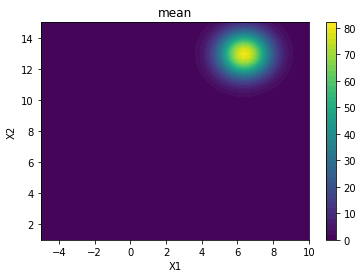

In [39]:
grid = 50
x1 = np.linspace(bounds[0][0], bounds[0][1], grid)
x2 = np.linspace(bounds[1][0], bounds[1][1], grid)
X1, X2 = np.meshgrid(x1, x2)
_X = np.hstack((X1.reshape(grid*grid,1),X2.reshape(grid*grid,1)))
_Y,var =  model.predict_f(_X)
plt.figure()    
plt.contourf(X1, X2, _Y.reshape((grid,grid)),grid)
plt.colorbar()
plt.xlabel('X1')
plt.ylabel('X2')
plt.title("mean")
plt.show()

## EI

In [17]:
x1 = np.linspace(bounds[0][0], bounds[0][1], grid)
x2 = np.linspace(bounds[1][0], bounds[1][1], grid)
X1, X2 = np.meshgrid(x1, x2)
_X = np.hstack((X1.reshape(grid*grid,1),X2.reshape(grid*grid,1)))
_Y = ei(_X, bounds, model)

NameError: name 'grid' is not defined

In [41]:
bounds

[(-5, 10), (1, 15)]

In [42]:
acq = lambda x: -1*ei(x, bounds, model)
x = minimize(acq,bounds)
x

array([[-5.,  1.]])

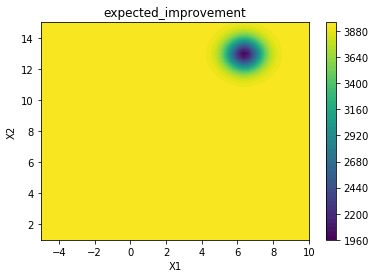

In [43]:
plt.figure()    
plt.contourf(X1, X2, _Y.reshape((grid,grid)),grid)
plt.colorbar()
plt.xlabel('X1')
plt.ylabel('X2')
plt.title("expected_improvement")
plt.show()

In [23]:
seed=3
obj_f = objective_noisy.f
kernel = gpflow.kernels.RBF(input_dim=2, ARD=True)
np.random.seed(seed=seed)
N_q=1
N = 10
queryei, valueei = bayesianOptimization(obj_f, 
                                        ei,
                                        bounds,
                                        kernel,
                                        depth_h = h,
                                        N = N,
                                        N_q = N_q
                                       )

0


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 5.772461
  Number of iterations: 30
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 5.772461
  Number of iterations: 30
  Number of functions evaluations: 31


1
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 13.477239
  Number of iterations: 9
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 13.477239
  Number of iterations: 9
  Number of functions evaluations: 14


2
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 19.690796
  Number of iterations: 2
  Number of functions evaluations: 8


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 19.690796
  Number of iterations: 2
  Number of functions evaluations: 8


3
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 25.677758
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 25.677758
  Number of iterations: 0
  Number of functions evaluations: 1


4
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 31.535668
  Number of iterations: 3
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 31.535668
  Number of iterations: 3
  Number of functions evaluations: 9


5
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 37.953547
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 37.953547
  Number of iterations: 0
  Number of functions evaluations: 1


6
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 42.886538
  Number of iterations: 20
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 42.886538
  Number of iterations: 20
  Number of functions evaluations: 36


7
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 48.211542
  Number of iterations: 6
  Number of functions evaluations: 8


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 48.211542
  Number of iterations: 6
  Number of functions evaluations: 8


8
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 54.386968
  Number of iterations: 6
  Number of functions evaluations: 7


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 54.386968
  Number of iterations: 6
  Number of functions evaluations: 7


In [24]:
queryei

array([[ 3.26196854, 10.91406952],
       [-5.        ,  1.        ],
       [-5.        ,  9.20689655],
       [ 3.27586207,  1.        ],
       [ 9.48275862,  5.34482759],
       [10.        , 15.        ],
       [-1.89655172, 15.        ],
       [10.        ,  1.        ],
       [-0.86206897,  5.82758621],
       [-5.        , 15.        ]])

In [25]:
valueei[:,0]

array([ 77.70867239, 275.56802697,  77.38381242,   2.82386862,
         9.36088647, 146.80949081,  38.35866398,   6.90725402,
        19.80938005,  18.59676175])

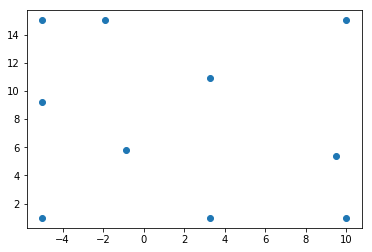

In [26]:
plt.scatter(queryei[:,0],queryei[:,1])

## Rollout 

In [20]:
grid = 10
x1 = np.linspace(bounds[0][0], bounds[0][1], grid)
x2 = np.linspace(bounds[1][0], bounds[1][1], grid)
X1, X2 = np.meshgrid(x1, x2)
_X = np.hstack((X1.reshape(grid*grid,1),X2.reshape(grid*grid,1)))

h=1
N_q=1
_Y = np.array([])
for i in range(_X.shape[0]):
    print(i)
    x = _X[i:i+1]
    y = rollout_utility_archive(x = x,
                        bounds = bounds,
                        func_policy=policy, 
                        depth_h = h, 
                        _queries = X, 
                        _values = Y, 
                        kernel=kernel,
                        N_q=N_q)
    _Y = np.concatenate([_Y,y[0]])
_Y = _Y.T

0


ValueError: Tensor("GPR-0d697196-14/likelihood/prior:0", shape=(), dtype=float64) must be from the same graph as Tensor("SquaredExponential-bd56505b-0/prior:0", shape=(), dtype=float64).

In [29]:
x1 = np.linspace(bounds[0][0], bounds[0][1], grid)
x2 = np.linspace(bounds[1][0], bounds[1][1], grid)
X1, X2 = np.meshgrid(x1, x2)
_X = np.hstack((X1.reshape(grid*grid,1),X2.reshape(grid*grid,1)))

h=1
N_q=1
_Y = np.array([])
for i in range(_X.shape[0]):
    print(i)
    x = _X[i:i+1]
    y = rollout_utility_archive(x = x,
                        bounds = bounds,
                        func_policy=policy, 
                        depth_h = h, 
                        _queries = X, 
                        _values = Y, 
                        kernel=kernel,
                        N_q=N_q)
    _Y = np.concatenate([_Y,y[0]])
_Y = _Y.T

0


INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: 5.532468
  Number of iterations: 1
  Number of functions evaluations: 43


INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: 5.532468
  Number of iterations: 1
  Number of functions evaluations: 43


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 8.818161
  Number of iterations: 28
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 8.818161
  Number of iterations: 28
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 8.818163
  Number of iterations: 2
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 8.818163
  Number of iterations: 2
  Number of functions evaluations: 4


1
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769279
  Number of iterations: 5
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769279
  Number of iterations: 5
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 8.786140
  Number of iterations: 15
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 8.786140
  Number of iterations: 15
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 8.786143
  Number of iterations: 1
  Number of functions evaluations: 3


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 8.786143
  Number of iterations: 1
  Number of functions evaluations: 3


2
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769276
  Number of iterations: 5
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769276
  Number of iterations: 5
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 8.719063
  Number of iterations: 14
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 8.719063
  Number of iterations: 14
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 8.719065
  Number of iterations: 1
  Number of functions evaluations: 3


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 8.719065
  Number of iterations: 1
  Number of functions evaluations: 3


3
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769324
  Number of iterations: 4
  Number of functions evaluations: 8


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769324
  Number of iterations: 4
  Number of functions evaluations: 8


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 8.582486
  Number of iterations: 16
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 8.582486
  Number of iterations: 16
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 8.582487
  Number of iterations: 1
  Number of functions evaluations: 3


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 8.582487
  Number of iterations: 1
  Number of functions evaluations: 3


4
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769281
  Number of iterations: 4
  Number of functions evaluations: 8


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769281
  Number of iterations: 4
  Number of functions evaluations: 8


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 8.333336
  Number of iterations: 13
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 8.333336
  Number of iterations: 13
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 8.333337
  Number of iterations: 1
  Number of functions evaluations: 3


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 8.333337
  Number of iterations: 1
  Number of functions evaluations: 3


5
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769301
  Number of iterations: 3
  Number of functions evaluations: 7


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769301
  Number of iterations: 3
  Number of functions evaluations: 7


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 7.908306
  Number of iterations: 14
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 7.908306
  Number of iterations: 14
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 7.908306
  Number of iterations: 1
  Number of functions evaluations: 3


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 7.908306
  Number of iterations: 1
  Number of functions evaluations: 3


6
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769292
  Number of iterations: 2
  Number of functions evaluations: 6


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769292
  Number of iterations: 2
  Number of functions evaluations: 6


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 7.414764
  Number of iterations: 14
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 7.414764
  Number of iterations: 14
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 7.414765
  Number of iterations: 4
  Number of functions evaluations: 5


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 7.414765
  Number of iterations: 4
  Number of functions evaluations: 5


7
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769274
  Number of iterations: 2
  Number of functions evaluations: 6


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769274
  Number of iterations: 2
  Number of functions evaluations: 6


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 6.872243
  Number of iterations: 7
  Number of functions evaluations: 8


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 6.872243
  Number of iterations: 7
  Number of functions evaluations: 8


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 6.872243
  Number of iterations: 8
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 6.872243
  Number of iterations: 8
  Number of functions evaluations: 9


8
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769307
  Number of iterations: 2
  Number of functions evaluations: 5


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769307
  Number of iterations: 2
  Number of functions evaluations: 5


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 6.301046
  Number of iterations: 9
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 6.301046
  Number of iterations: 9
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 6.301045
  Number of iterations: 10
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 6.301045
  Number of iterations: 10
  Number of functions evaluations: 11


9
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769274
  Number of iterations: 2
  Number of functions evaluations: 5


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769274
  Number of iterations: 2
  Number of functions evaluations: 5


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 5.489905
  Number of iterations: 12
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 5.489905
  Number of iterations: 12
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 5.489905
  Number of iterations: 10
  Number of functions evaluations: 12


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 5.489905
  Number of iterations: 10
  Number of functions evaluations: 12


10
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769296
  Number of iterations: 1
  Number of functions evaluations: 3


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769296
  Number of iterations: 1
  Number of functions evaluations: 3


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.070766
  Number of iterations: 17
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.070766
  Number of iterations: 17
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.070764
  Number of iterations: 2
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.070764
  Number of iterations: 2
  Number of functions evaluations: 4


11
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769279
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769279
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.847287
  Number of iterations: 11
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.847287
  Number of iterations: 11
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.847287
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.847287
  Number of iterations: 1
  Number of functions evaluations: 4


12
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769276
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769276
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.840905
  Number of iterations: 11
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.840905
  Number of iterations: 11
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.840905
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.840905
  Number of iterations: 1
  Number of functions evaluations: 4


13
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769277
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769277
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.833920
  Number of iterations: 10
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.833920
  Number of iterations: 10
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.833920
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.833920
  Number of iterations: 1
  Number of functions evaluations: 4


14
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769284
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769284
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.844087
  Number of iterations: 9
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.844087
  Number of iterations: 9
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.844087
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.844087
  Number of iterations: 1
  Number of functions evaluations: 4


15
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769274
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769274
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.839162
  Number of iterations: 7
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.839162
  Number of iterations: 7
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.839162
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.839162
  Number of iterations: 1
  Number of functions evaluations: 4


16
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769275
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769275
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.840113
  Number of iterations: 2
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.840113
  Number of iterations: 2
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.840113
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.840113
  Number of iterations: 1
  Number of functions evaluations: 4


17
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769274
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769274
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.839607
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.839607
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.839607
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.839607
  Number of iterations: 1
  Number of functions evaluations: 4


18
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769285
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769285
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 5.302372
  Number of iterations: 5
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 5.302372
  Number of iterations: 5
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 5.302372
  Number of iterations: 5
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 5.302372
  Number of iterations: 5
  Number of functions evaluations: 9


19
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769311
  Number of iterations: 1
  Number of functions evaluations: 3


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769311
  Number of iterations: 1
  Number of functions evaluations: 3


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.027745
  Number of iterations: 4
  Number of functions evaluations: 8


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.027745
  Number of iterations: 4
  Number of functions evaluations: 8


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.027745
  Number of iterations: 4
  Number of functions evaluations: 8


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.027745
  Number of iterations: 4
  Number of functions evaluations: 8


20
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769330
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769330
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.853539
  Number of iterations: 10
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.853539
  Number of iterations: 10
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.853539
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.853539
  Number of iterations: 1
  Number of functions evaluations: 4


21
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769279
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769279
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.842539
  Number of iterations: 10
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.842539
  Number of iterations: 10
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.842539
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.842539
  Number of iterations: 1
  Number of functions evaluations: 4


22
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769289
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769289
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.845444
  Number of iterations: 10
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.845444
  Number of iterations: 10
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.845444
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.845444
  Number of iterations: 1
  Number of functions evaluations: 4


23
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769275
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769275
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.839715
  Number of iterations: 8
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.839715
  Number of iterations: 8
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.839715
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.839715
  Number of iterations: 1
  Number of functions evaluations: 4


24
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769284
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769284
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.844225
  Number of iterations: 7
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.844225
  Number of iterations: 7
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.844225
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.844225
  Number of iterations: 1
  Number of functions evaluations: 4


25
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769274
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769274
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.839265
  Number of iterations: 4
  Number of functions evaluations: 12


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.839265
  Number of iterations: 4
  Number of functions evaluations: 12


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.839265
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.839265
  Number of iterations: 1
  Number of functions evaluations: 4


26
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769290
  Number of iterations: 2
  Number of functions evaluations: 3


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769290
  Number of iterations: 2
  Number of functions evaluations: 3


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 0.252622
  Number of iterations: 13
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 0.252622
  Number of iterations: 13
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 0.252626
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 0.252626
  Number of iterations: 1
  Number of functions evaluations: 4


27
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769274
  Number of iterations: 2
  Number of functions evaluations: 5


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769274
  Number of iterations: 2
  Number of functions evaluations: 5


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 5.342734
  Number of iterations: 6
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 5.342734
  Number of iterations: 6
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 5.342734
  Number of iterations: 6
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 5.342734
  Number of iterations: 6
  Number of functions evaluations: 10


28
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769323
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769323
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.851369
  Number of iterations: 5
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.851369
  Number of iterations: 5
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.851369
  Number of iterations: 5
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.851369
  Number of iterations: 5
  Number of functions evaluations: 11


29
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769323
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769323
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.851375
  Number of iterations: 21
  Number of functions evaluations: 55


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.851375
  Number of iterations: 21
  Number of functions evaluations: 55


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.851375
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.851375
  Number of iterations: 1
  Number of functions evaluations: 4


30
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769291
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769291
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.830589
  Number of iterations: 10
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.830589
  Number of iterations: 10
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.830589
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.830589
  Number of iterations: 1
  Number of functions evaluations: 4


31
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769278
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769278
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.841989
  Number of iterations: 10
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.841989
  Number of iterations: 10
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.841989
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.841989
  Number of iterations: 1
  Number of functions evaluations: 4


32
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769312
  Number of iterations: 1
  Number of functions evaluations: 3


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769312
  Number of iterations: 1
  Number of functions evaluations: 3


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.027802
  Number of iterations: 5
  Number of functions evaluations: 8


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.027802
  Number of iterations: 5
  Number of functions evaluations: 8


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.027802
  Number of iterations: 5
  Number of functions evaluations: 8


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.027802
  Number of iterations: 5
  Number of functions evaluations: 8


33
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769332
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769332
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.852697
  Number of iterations: 13
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.852697
  Number of iterations: 13
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.852697
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.852697
  Number of iterations: 1
  Number of functions evaluations: 4


34
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769291
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769291
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.829171
  Number of iterations: 10
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.829171
  Number of iterations: 10
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.829171
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.829171
  Number of iterations: 1
  Number of functions evaluations: 4


35
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769288
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769288
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.844946
  Number of iterations: 11
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.844946
  Number of iterations: 11
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.844946
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.844946
  Number of iterations: 1
  Number of functions evaluations: 4


36
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769285
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769285
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.830650
  Number of iterations: 8
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.830650
  Number of iterations: 8
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.830650
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.830650
  Number of iterations: 1
  Number of functions evaluations: 4


37
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769274
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769274
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.845198
  Number of iterations: 8
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.845198
  Number of iterations: 8
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.845198
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.845198
  Number of iterations: 1
  Number of functions evaluations: 4


38
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769274
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769274
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.839429
  Number of iterations: 8
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.839429
  Number of iterations: 8
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.839429
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.839429
  Number of iterations: 1
  Number of functions evaluations: 4


39
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769275
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769275
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.841076
  Number of iterations: 8
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.841076
  Number of iterations: 8
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.841076
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.841076
  Number of iterations: 1
  Number of functions evaluations: 4


40
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769290
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769290
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.847110
  Number of iterations: 10
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.847110
  Number of iterations: 10
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.847110
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.847110
  Number of iterations: 1
  Number of functions evaluations: 4


41
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769274
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769274
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.839700
  Number of iterations: 10
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.839700
  Number of iterations: 10
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.839700
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.839700
  Number of iterations: 1
  Number of functions evaluations: 4


42
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769318
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769318
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.850898
  Number of iterations: 10
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.850898
  Number of iterations: 10
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.850898
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.850898
  Number of iterations: 1
  Number of functions evaluations: 4


43
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769274
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769274
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.837670
  Number of iterations: 11
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.837670
  Number of iterations: 11
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.837670
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.837670
  Number of iterations: 1
  Number of functions evaluations: 4


44
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769275
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769275
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.835206
  Number of iterations: 9
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.835206
  Number of iterations: 9
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.835206
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.835206
  Number of iterations: 1
  Number of functions evaluations: 4


45
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769278
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769278
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.832972
  Number of iterations: 10
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.832972
  Number of iterations: 10
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.832972
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.832972
  Number of iterations: 1
  Number of functions evaluations: 4


46
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769276
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769276
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.840500
  Number of iterations: 7
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.840500
  Number of iterations: 7
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.840500
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.840500
  Number of iterations: 1
  Number of functions evaluations: 4


47
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769274
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769274
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.846467
  Number of iterations: 9
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.846467
  Number of iterations: 9
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.846467
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.846467
  Number of iterations: 1
  Number of functions evaluations: 4


48
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769279
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769279
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.843617
  Number of iterations: 7
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.843617
  Number of iterations: 7
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.843617
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.843617
  Number of iterations: 1
  Number of functions evaluations: 4


49
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769317
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769317
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.851853
  Number of iterations: 7
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.851853
  Number of iterations: 7
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.851853
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.851853
  Number of iterations: 1
  Number of functions evaluations: 4


50
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769309
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769309
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.850855
  Number of iterations: 10
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.850855
  Number of iterations: 10
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.850855
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.850855
  Number of iterations: 1
  Number of functions evaluations: 4


51
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769275
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769275
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.840155
  Number of iterations: 10
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.840155
  Number of iterations: 10
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.840155
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.840155
  Number of iterations: 1
  Number of functions evaluations: 4


52
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769314
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769314
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.850381
  Number of iterations: 10
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.850381
  Number of iterations: 10
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.850381
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.850381
  Number of iterations: 1
  Number of functions evaluations: 4


53
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769274
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769274
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.839182
  Number of iterations: 11
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.839182
  Number of iterations: 11
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.839182
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.839182
  Number of iterations: 1
  Number of functions evaluations: 4


54
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769276
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769276
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.834684
  Number of iterations: 9
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.834684
  Number of iterations: 9
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.834684
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.834684
  Number of iterations: 1
  Number of functions evaluations: 4


55
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769274
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769274
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.838627
  Number of iterations: 11
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.838627
  Number of iterations: 11
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.838627
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.838627
  Number of iterations: 1
  Number of functions evaluations: 4


56
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769274
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769274
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.837288
  Number of iterations: 8
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.837288
  Number of iterations: 8
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.837288
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.837288
  Number of iterations: 1
  Number of functions evaluations: 4


57
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769274
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769274
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.845693
  Number of iterations: 7
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.845693
  Number of iterations: 7
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.845693
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.845693
  Number of iterations: 1
  Number of functions evaluations: 4


58
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769324
  Number of iterations: 1
  Number of functions evaluations: 3


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769324
  Number of iterations: 1
  Number of functions evaluations: 3


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.029984
  Number of iterations: 4
  Number of functions evaluations: 8


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.029984
  Number of iterations: 4
  Number of functions evaluations: 8


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.029984
  Number of iterations: 4
  Number of functions evaluations: 8


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.029984
  Number of iterations: 4
  Number of functions evaluations: 8


59
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769293
  Number of iterations: 1
  Number of functions evaluations: 3


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769293
  Number of iterations: 1
  Number of functions evaluations: 3


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.025275
  Number of iterations: 12
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.025275
  Number of iterations: 12
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.025275
  Number of iterations: 10
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.025275
  Number of iterations: 10
  Number of functions evaluations: 22


60
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769276
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769276
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.853721
  Number of iterations: 14
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.853721
  Number of iterations: 14
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.853721
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.853721
  Number of iterations: 1
  Number of functions evaluations: 4


61
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769277
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769277
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.834015
  Number of iterations: 10
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.834015
  Number of iterations: 10
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.834015
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.834015
  Number of iterations: 1
  Number of functions evaluations: 4


62
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769305
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769305
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.848789
  Number of iterations: 10
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.848789
  Number of iterations: 10
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.848789
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.848789
  Number of iterations: 1
  Number of functions evaluations: 4


63
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769284
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769284
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.843974
  Number of iterations: 11
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.843974
  Number of iterations: 11
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.843974
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.843974
  Number of iterations: 1
  Number of functions evaluations: 4


64
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769277
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769277
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.833739
  Number of iterations: 9
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.833739
  Number of iterations: 9
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.833739
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.833739
  Number of iterations: 1
  Number of functions evaluations: 4


65
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769298
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769298
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.847293
  Number of iterations: 11
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.847293
  Number of iterations: 11
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.847293
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.847293
  Number of iterations: 1
  Number of functions evaluations: 4


66
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769274
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769274
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.836990
  Number of iterations: 7
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.836990
  Number of iterations: 7
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.836990
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.836990
  Number of iterations: 1
  Number of functions evaluations: 4


67
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769274
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769274
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.846657
  Number of iterations: 8
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.846657
  Number of iterations: 8
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.846657
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.846657
  Number of iterations: 1
  Number of functions evaluations: 4


68
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769274
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769274
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.837663
  Number of iterations: 8
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.837663
  Number of iterations: 8
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.837663
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.837663
  Number of iterations: 1
  Number of functions evaluations: 4


69
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769276
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769276
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.841772
  Number of iterations: 8
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.841772
  Number of iterations: 8
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.841772
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.841772
  Number of iterations: 1
  Number of functions evaluations: 4


70
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769285
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769285
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.845688
  Number of iterations: 10
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.845688
  Number of iterations: 10
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.845688
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.845688
  Number of iterations: 1
  Number of functions evaluations: 4


71
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769275
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769275
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.839981
  Number of iterations: 10
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.839981
  Number of iterations: 10
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.839981
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.839981
  Number of iterations: 1
  Number of functions evaluations: 4


72
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769333
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769333
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.853020
  Number of iterations: 10
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.853020
  Number of iterations: 10
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.853020
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.853020
  Number of iterations: 1
  Number of functions evaluations: 4


73
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769297
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769297
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.847318
  Number of iterations: 11
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.847318
  Number of iterations: 11
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.847318
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.847318
  Number of iterations: 1
  Number of functions evaluations: 4


74
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769277
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769277
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.833950
  Number of iterations: 11
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.833950
  Number of iterations: 11
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.833950
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.833950
  Number of iterations: 1
  Number of functions evaluations: 4


75
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769274
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769274
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.836129
  Number of iterations: 9
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.836129
  Number of iterations: 9
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.836129
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.836129
  Number of iterations: 1
  Number of functions evaluations: 4


76
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769274
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769274
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.838901
  Number of iterations: 7
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.838901
  Number of iterations: 7
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.838901
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.838901
  Number of iterations: 1
  Number of functions evaluations: 4


77
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769274
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769274
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.845374
  Number of iterations: 8
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.845374
  Number of iterations: 8
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.845374
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.845374
  Number of iterations: 1
  Number of functions evaluations: 4


78
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769281
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769281
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.844586
  Number of iterations: 7
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.844586
  Number of iterations: 7
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.844586
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.844586
  Number of iterations: 1
  Number of functions evaluations: 4


79
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769327
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769327
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.853523
  Number of iterations: 7
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.853523
  Number of iterations: 7
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.853523
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.853523
  Number of iterations: 1
  Number of functions evaluations: 4


80
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769274
  Number of iterations: 2
  Number of functions evaluations: 5


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769274
  Number of iterations: 2
  Number of functions evaluations: 5


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 5.377529
  Number of iterations: 5
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 5.377529
  Number of iterations: 5
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 5.377529
  Number of iterations: 5
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 5.377529
  Number of iterations: 5
  Number of functions evaluations: 9


81
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769327
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769327
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.853088
  Number of iterations: 9
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.853088
  Number of iterations: 9
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.853088
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.853088
  Number of iterations: 1
  Number of functions evaluations: 4


82
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769281
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769281
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.843009
  Number of iterations: 10
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.843009
  Number of iterations: 10
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.843009
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.843009
  Number of iterations: 1
  Number of functions evaluations: 4


83
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769302
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769302
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.848235
  Number of iterations: 11
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.848235
  Number of iterations: 11
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.848235
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.848235
  Number of iterations: 1
  Number of functions evaluations: 4


84
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769275
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769275
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.835403
  Number of iterations: 11
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.835403
  Number of iterations: 11
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.835403
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.835403
  Number of iterations: 1
  Number of functions evaluations: 4


85
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769277
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769277
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.833996
  Number of iterations: 10
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.833996
  Number of iterations: 10
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.833996
  Number of iterations: 1
  Number of functions evaluations: 4


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.833996
  Number of iterations: 1
  Number of functions evaluations: 4


86
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769288
  Number of iterations: 2
  Number of functions evaluations: 3


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769288
  Number of iterations: 2
  Number of functions evaluations: 3


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 0.410576
  Number of iterations: 12
  Number of functions evaluations: 23


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 0.410576
  Number of iterations: 12
  Number of functions evaluations: 23


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 0.410573
  Number of iterations: 4
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 0.410573
  Number of iterations: 4
  Number of functions evaluations: 10


87
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769276
  Number of iterations: 3
  Number of functions evaluations: 7


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769276
  Number of iterations: 3
  Number of functions evaluations: 7


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 7.255479
  Number of iterations: 9
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 7.255479
  Number of iterations: 9
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 7.255479
  Number of iterations: 9
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 7.255479
  Number of iterations: 9
  Number of functions evaluations: 10


88
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769303
  Number of iterations: 3
  Number of functions evaluations: 6


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769303
  Number of iterations: 3
  Number of functions evaluations: 6


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 6.768949
  Number of iterations: 4
  Number of functions evaluations: 5


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 6.768949
  Number of iterations: 4
  Number of functions evaluations: 5


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 6.768949
  Number of iterations: 4
  Number of functions evaluations: 5


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 6.768949
  Number of iterations: 4
  Number of functions evaluations: 5


89
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769281
  Number of iterations: 2
  Number of functions evaluations: 5


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769281
  Number of iterations: 2
  Number of functions evaluations: 5


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 5.926728
  Number of iterations: 6
  Number of functions evaluations: 8


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 5.926728
  Number of iterations: 6
  Number of functions evaluations: 8


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 5.926728
  Number of iterations: 6
  Number of functions evaluations: 8


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 5.926728
  Number of iterations: 6
  Number of functions evaluations: 8


90
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769316
  Number of iterations: 1
  Number of functions evaluations: 3


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769316
  Number of iterations: 1
  Number of functions evaluations: 3


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.028275
  Number of iterations: 5
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.028275
  Number of iterations: 5
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.028275
  Number of iterations: 5
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.028275
  Number of iterations: 5
  Number of functions evaluations: 9


91
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769336
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769336
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.853150
  Number of iterations: 5
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.853150
  Number of iterations: 5
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.853150
  Number of iterations: 5
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.853150
  Number of iterations: 5
  Number of functions evaluations: 10


92
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769336
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769336
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.853136
  Number of iterations: 5
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.853136
  Number of iterations: 5
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.853136
  Number of iterations: 5
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.853136
  Number of iterations: 5
  Number of functions evaluations: 11


93
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769336
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769336
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.853125
  Number of iterations: 6
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.853125
  Number of iterations: 6
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.853125
  Number of iterations: 6
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.853125
  Number of iterations: 6
  Number of functions evaluations: 13


94
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769336
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769336
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.853117
  Number of iterations: 2
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.853117
  Number of iterations: 2
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.853117
  Number of iterations: 2
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.853117
  Number of iterations: 2
  Number of functions evaluations: 10


95
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769336
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769336
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.853113
  Number of iterations: 2
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.853113
  Number of iterations: 2
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.853113
  Number of iterations: 2
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.853113
  Number of iterations: 2
  Number of functions evaluations: 10


96
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769336
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769336
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.853112
  Number of iterations: 2
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.853112
  Number of iterations: 2
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.853112
  Number of iterations: 2
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.853112
  Number of iterations: 2
  Number of functions evaluations: 10


97
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769336
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769336
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.853114
  Number of iterations: 2
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.853114
  Number of iterations: 2
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.853114
  Number of iterations: 2
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.853114
  Number of iterations: 2
  Number of functions evaluations: 10


98
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769336
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769336
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.853119
  Number of iterations: 6
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.853119
  Number of iterations: 6
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.853119
  Number of iterations: 6
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.853119
  Number of iterations: 6
  Number of functions evaluations: 13


99
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769336
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.769336
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.853128
  Number of iterations: 5
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.853128
  Number of iterations: 5
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.853128
  Number of iterations: 5
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.853128
  Number of iterations: 5
  Number of functions evaluations: 11


ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'SquaredExponential-d0e90424-316/variance/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/taku/miniconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/taku/miniconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/taku/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/taku/miniconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/taku/miniconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()  File "/home/taku/miniconda3/lib/python3.6/site-packages/tornado

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'SquaredExponential-d0e90424-316/variance/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/taku/miniconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/taku/miniconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/taku/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/taku/miniconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/taku/miniconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()  File "/home/taku/miniconda3/lib/python3.6/site-packages/tornado

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'SquaredExponential-d0e90424-316/lengthscales/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/taku/miniconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/taku/miniconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/taku/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/taku/miniconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/taku/miniconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()  File "/home/taku/miniconda3/lib/python3.6/site-packages/tor

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'SquaredExponential-d0e90424-316/lengthscales/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/taku/miniconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/taku/miniconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/taku/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/taku/miniconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/taku/miniconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()  File "/home/taku/miniconda3/lib/python3.6/site-packages/tor

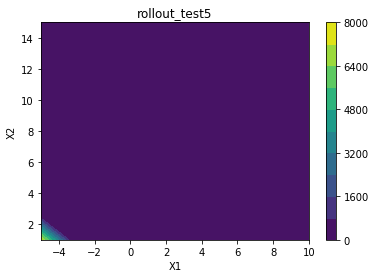

In [32]:
plt.figure()    
plt.contourf(X1, X2, _Y.reshape((grid,grid)),grid)
plt.colorbar()
plt.xlabel('X1')
plt.ylabel('X2')
plt.title("rollout_test5")
plt.show()

In [31]:
obj_f = objective_true.f
kernel = gpflow.kernels.RBF(input_dim=2, ARD=True)
seed = 5

np.random.seed(seed=seed)

h=1
N_q=3
N = 10

queryro, valuero = bayesianOptimization(obj_f, 
                                        rollout_utility_archive,
                                        bounds,
                                        kernel,
                                        depth_h = h,
                                        N = N,
                                        N_q = N_q
                                       )

0


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.731403
  Number of iterations: 24
  Number of functions evaluations: 25


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 4.731403
  Number of iterations: 24
  Number of functions evaluations: 25


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 15.265076
  Number of iterations: 21
  Number of functions evaluations: 25


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 15.265076
  Number of iterations: 21
  Number of functions evaluations: 25


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 15.240336
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 15.240336
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 8.769655
  Number of iterations: 5
  Number of functions evaluations: 46


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 8.769655
  Number of iterations: 5
  Number of functions evaluations: 46


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 8.769653
  Number of iterations: 1
  Number of functions evaluations: 2


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 8.769653
  Number of iterations: 1
  Number of functions evaluations: 2


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 15.261994
  Number of iterations: 21
  Number of functions evaluations: 25


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 15.261994
  Number of iterations: 21
  Number of functions evaluations: 25


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 15.236399
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 15.236399
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 6.612259
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 6.612259
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 321.053185
  Number of iterations: 21
  Number of functions evaluations: 29


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 321.053185
  Number of iterations: 21
  Number of functions evaluations: 29


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 289.041259
  Number of iterations: 5
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 289.041259
  Number of iterations: 5
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 19.019101
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 19.019101
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 19.019101
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 19.019101
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 280.034414
  Number of iterations: 3
  Number of functions evaluations: 30


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 280.034414
  Number of iterations: 3
  Number of functions evaluations: 30


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 333.231012
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 333.231012
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 9.625020
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 9.625020
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 111647.310711
  Number of iterations: 21
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 111647.310711
  Number of iterations: 21
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 140068.801424
  Number of iterations: 4
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 140068.801424
  Number of iterations: 4
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 24.946730
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 24.946730
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 24.946730
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 24.946730
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 122467.358156
  Number of iterations: 3
  Number of functions evaluations: 30


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 122467.358156
  Number of iterations: 3
  Number of functions evaluations: 30


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 97827.516238
  Number of iterations: 3
  Number of functions evaluations: 30


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 97827.516238
  Number of iterations: 3
  Number of functions evaluations: 30


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 12.700260
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 12.700260
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 58778044.293190
  Number of iterations: 21
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 58778044.293190
  Number of iterations: 21
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 55063238.471935
  Number of iterations: 5
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 55063238.471935
  Number of iterations: 5
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 30.603937
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 30.603937
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 30.603937
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 30.603937
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 55063238.471935
  Number of iterations: 5
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 55063238.471935
  Number of iterations: 5
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 55063238.471935
  Number of iterations: 5
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 55063238.471935
  Number of iterations: 5
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 15.301969
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 15.301969
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 11440543877.539351
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 11440543877.539351
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 22825856689.783653
  Number of iterations: 1
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 22825856689.783653
  Number of iterations: 1
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 35.924303
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 35.924303
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 35.924303
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 35.924303
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 22825856689.783653
  Number of iterations: 1
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 22825856689.783653
  Number of iterations: 1
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 22825856689.783653
  Number of iterations: 1
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 22825856689.783653
  Number of iterations: 1
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 17.962152
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 17.962152
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2371124375695.237793
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2371124375695.237793
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 4730311093681.236328
  Number of iterations: 1
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 4730311093681.236328
  Number of iterations: 1
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 41.231182
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 41.231182
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 41.231182
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 41.231182
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 4730311093681.236328
  Number of iterations: 1
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 4730311093681.236328
  Number of iterations: 1
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 4730311093681.236328
  Number of iterations: 1
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 4730311093681.236328
  Number of iterations: 1
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 20.615591
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 20.615591
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814702365.750000
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814702365.750000
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814599827.437500
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814599827.437500
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 41.231182
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 41.231182
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 41.231182
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 41.231182
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814087029.875000
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814087029.875000
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814702397.562500
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814702397.562500
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 20.615591
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 20.615591
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814804768.125000
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814804768.125000
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334815061169.125000
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334815061169.125000
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 41.231182
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 41.231182
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 41.231182
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 41.231182
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814650922.687500
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814650922.687500
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814343256.312500
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814343256.312500
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 20.615591
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 20.615591
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814599653.562500
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814599653.562500
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814599662.062500
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814599662.062500
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 41.231182
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 41.231182
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 41.231182
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 41.231182
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814292019.687500
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814292019.687500
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814804788.937500
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814804788.937500
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 20.615591
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 20.615591
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814548440.625000
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814548440.625000
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814804827.437500
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814804827.437500
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 41.231182
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 41.231182
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 41.231182
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 41.231182
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814650990.687500
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814650990.687500
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814240753.125000
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814240753.125000
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 20.615591
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 20.615591
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814702512.625000
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814702512.625000
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814292271.062500
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814292271.062500
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 41.231182
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 41.231182
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 41.231182
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 41.231182
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814805066.062500
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814805066.062500
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814753778.937500
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814753778.937500
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 20.615591
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 20.615591
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814805029.000000
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814805029.000000
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814599912.937500
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814599912.937500
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 41.231182
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 41.231182
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 41.231182
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 41.231182
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814651218.250000
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814651218.250000
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814599947.937500
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814599947.937500
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 20.615591
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 20.615591
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814240798.187500
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814240798.187500
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814702289.375000
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814702289.375000
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 41.231182
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 41.231182
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 41.231182
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 41.231182
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814292059.562500
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814292059.562500
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814497187.000000
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814497187.000000
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 20.615591
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 20.615591
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814599803.812500
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814599803.812500
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814702354.437500
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814702354.437500
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 41.231182
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 41.231182
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 41.231182
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 41.231182
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814497238.187500
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814497238.187500
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814292129.375000
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814292129.375000
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 20.615591
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 20.615591
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814804854.500000
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814804854.500000
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814753544.937500
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814753544.937500
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 41.231182
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 41.231182
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 41.231182
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 41.231182
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814343299.562500
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814343299.562500
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814753511.875000
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814753511.875000
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 20.615591
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 20.615591
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814753986.000000
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814753986.000000
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814600149.437500
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814600149.437500
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 41.231182
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 41.231182
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 41.231182
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 41.231182
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814702696.562500
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814702696.562500
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814651426.687500
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814651426.687500
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 20.615591
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 20.615591
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814702765.250000
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814702765.250000
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814651520.125000
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814651520.125000
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 41.231182
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 41.231182
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 41.231182
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 41.231182
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334815266911.437500
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334815266911.437500
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814292615.375000
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814292615.375000
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 20.615591
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 20.615591
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814702234.500000
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814702234.500000
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814445815.875000
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 478334814445815.875000
  Number of iterations: 23
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 41.231182
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 41.231182
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 41.231182
  Number of iterations: 0
  Number of functions evaluations: 1


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 41.231182
  Number of iterations: 0
  Number of functions evaluations: 1


KeyboardInterrupt: 

In [ ]:
queryro

In [ ]:
valuero[:,0]

In [621]:
queryei

array([[-1.67010243, 13.19025229],
       [-1.89921267, 13.86055271],
       [-5.        ,  1.        ],
       [-5.        ,  1.        ],
       [-5.        ,  1.        ],
       [-5.        ,  1.        ],
       [-5.        ,  1.        ],
       [-5.        ,  1.        ],
       [-5.        ,  1.        ],
       [-5.        ,  1.        ],
       [-5.        ,  1.        ],
       [-5.        ,  1.        ],
       [-5.        ,  1.        ],
       [-5.        ,  1.        ],
       [-5.        ,  1.        ],
       [-5.        ,  1.        ],
       [-5.        ,  1.        ],
       [-5.        ,  1.        ],
       [-5.        ,  1.        ],
       [-5.        ,  1.        ],
       [-5.        ,  1.        ],
       [-5.        ,  1.        ],
       [-5.        ,  1.        ],
       [-5.        ,  1.        ],
       [-5.        ,  1.        ],
       [-5.        ,  1.        ],
       [-5.        ,  1.        ],
       [-5.        ,  1.        ],
       [-5.        ,

In [622]:
valueei[:,0]

array([ 27.6956348 ,  26.99112447, 275.76533723, 275.91262436,
       275.663453  , 275.69521258, 275.77313657, 275.72138925,
       275.63509978, 275.73388859, 275.71849335, 275.81472341,
       275.58789739, 275.68435834, 275.86951535, 275.94010935,
       275.60325829, 275.818861  , 275.65631546, 275.66869093,
       275.66718833, 275.71212545, 275.85402023, 275.82561837,
       275.76029067, 275.71804516, 275.75470513, 275.7437832 ,
       275.83368158, 275.69121908])

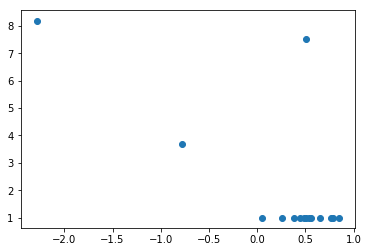

In [539]:
plt.scatter(queryro[:,0],queryro[:,1])

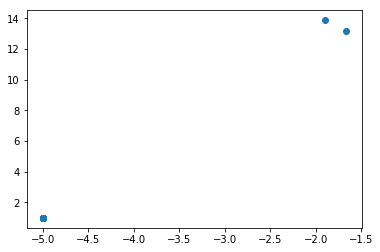

In [623]:
plt.scatter(queryei[:,0],queryei[:,1])